### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Oppgave 1

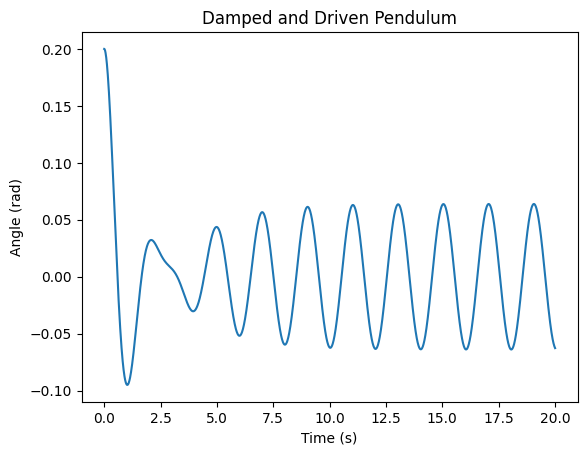

In [ ]:
L = 1.0 
g = 9.81
q = 1.0 
OMEGA_D = 3.13 
F_D_ML = 0.2
m = F_D_ML / (0.2 * L)

def damped_pendulum_motor(t, y, q_coef, W_d):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g/L)*theta - q_coef*omega + F_D_ML*np.sin(W_d*t)
    return np.array([dtheta_dt, domega_dt])

def RTK_4(theta0, omega0, t0, tmax, dt, f=damped_pendulum_motor, W_d=OMEGA_D, q_coef=q):
    y0 = np.array([theta0, omega0])
    t = np.arange(t0, tmax+dt, dt)

    y = np.zeros((len(t), 2))
    y[0] = y0
    for i in range(1, len(t)):
        k1 = dt*f(t[i-1], y[i-1], q_coef, W_d)
        k2 = dt*f(t[i-1] + 0.5*dt, y[i-1] + 0.5*k1, q_coef, W_d)
        k3 = dt*f(t[i-1] + 0.5*dt, y[i-1] + 0.5*k2, q_coef, W_d)
        k4 = dt*f(t[i-1] + dt, y[i-1] + k3, q_coef, W_d)
        y[i] = y[i-1] + (1/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    theta, omega = [y[0] for y in y], [y[1] for y in y]
    return theta, omega, t

y, omega, t = RTK_4(theta0=0.2, omega0=0.0, W_d=OMEGA_D, t0=0.0, tmax=20.0, dt=0.01)

# Plot the results
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Damped and Driven Pendulum')
plt.show()




In [ ]:
def pendulum_EulerChromer(theta0, omega0, t0, tmax, dt):
    theta = np.zeros(int(tmax/dt) + 1)
    omega = np.zeros(int(tmax/dt) + 1)

    theta[0] = theta0
    omega[0] = omega0
    
    t = np.arange(t0, tmax+dt, dt)
    
    steps = int(tmax/dt)
    def domega_dt(theta, omega, t):
        return -(g / L) * theta - (q / (m * L ** 2)) * omega + (F_D_ML / (m * L ** 2)) * np.sin(OMEGA_D * t)

    for i in range(1, steps):
        omega[i] = omega[i - 1] + dt * domega_dt(theta[i - 1], omega[i - 1], t[i - 1])
        theta[i] = theta[i - 1] + dt * omega[i]
        t[i] = t[i - 1] + dt

    return theta[:-1], omega[:-1], t[:-1]

# Oppgave 2

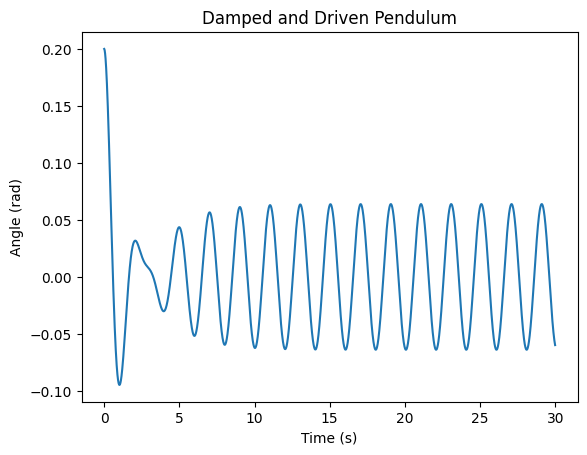

In [ ]:
theta_eu, omega_eu, t_eu = pendulum_EulerChromer(theta0=0.2, omega0=0.0, t0=0.0, tmax=30.0, dt=0.01)

# Plot the results
plt.plot(t_eu, theta_eu)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Damped and Driven Pendulum')
plt.show()

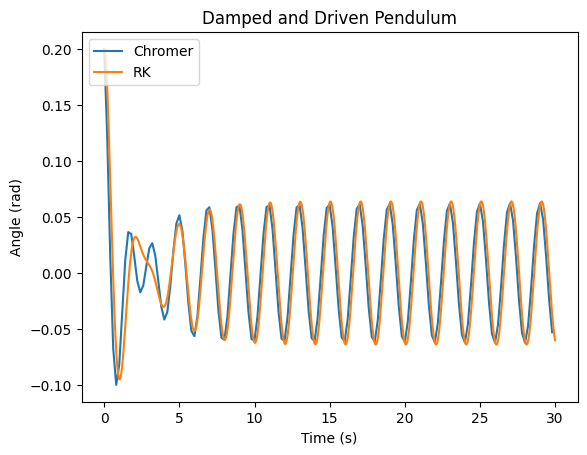

In [ ]:
y_2, omega_2, t_2 = RTK_4(theta0=0.2, omega0=0.0, t0=0.0, tmax=30.0, dt=0.01)
theta_eu_2, omega_eu_2, t_eu_2 = pendulum_EulerChromer(theta0=0.2, omega0=0.0, t0=0.0, tmax=30.0, dt=0.2)

plt.plot(t_eu_2, theta_eu_2, label="Chromer")
plt.plot(t_2, y_2, label="RK")

plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Damped and Driven Pendulum')
plt.legend(loc="upper left")
plt.show()

In [ ]:
def E_K(m, l, w):
    return 0.5 * m * (l**2) * (w**2)

def E_P(m, g, l, theta):
    return 0.5 * m * g * l * theta**2

def E_T(m, l, g, w, theta):
    return E_K(m, l, w) + E_P(m, g, l, theta)

In [ ]:
t_start = 0.001
t_end = 0.1
step = 0.001
N = int(0.1/0.001 - 1)
times = np.linspace(t_start, t_end, N)
E_D_RTK = np.zeros(N+1)
E_D_CHROMER = np.zeros(N+1)

# Må finne analytisk slutt-energi
# 1/2x**2*k

end_energy = 1/2*m*(OMEGA_D)**2*(F_D_ML/(np.sqrt((OMEGA_D**2-(g/L))**2+(q*OMEGA_D)**2)))**2 # Analytical energy

for i in range(N):
    # E_0 = E_T(m, L, g, 0.0, 0.2)
    new_RK4_theta, new_RK4_w, new_RK4_t = RTK_4(theta0=0.2, omega0=0.0, W_d=OMEGA_D, t0=0.0, tmax=20.0, dt=times[i])
    new_chromer_theta, new_chromer_w, new_chromer_t = pendulum_EulerChromer(theta0=0.2, omega0=0.0, t0=0.0, tmax=20.0, dt=times[i])
    E_D_RTK[i] = abs(E_T(m, L, g, new_RK4_w[-1], new_RK4_theta[-1]) - end_energy)
    E_D_CHROMER[i] = abs(E_T(m, L, g, new_chromer_w[-1], new_chromer_theta[-1]) - end_energy)



Feedback:

definere E_0 for hvert tidssteg, men fortsatt problemer med det.
Definer E som den høyeste eller laveste energien, slik at vi basically bare sammenligner toppene eller bunnene. 

Heller sammenligne bevaring av mekanisk energi, altså topp - bunn. Dette burde være nærme 0.

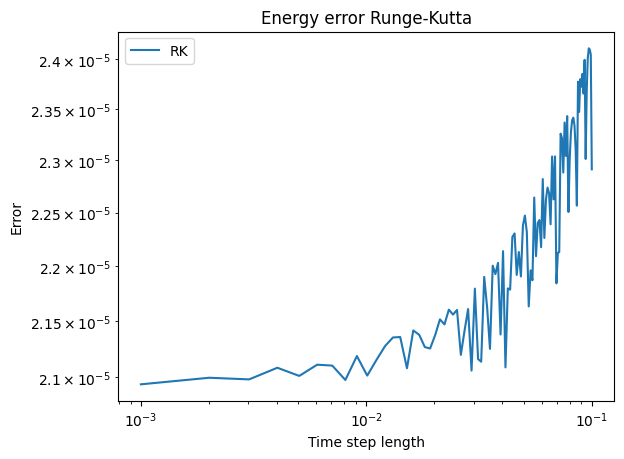

In [ ]:
plt.loglog(times, E_D_RTK[:-1], label="RK")

plt.xlabel('Time step length')
plt.ylabel('Error')
plt.title('Energy error Runge-Kutta')
plt.legend()
plt.show()

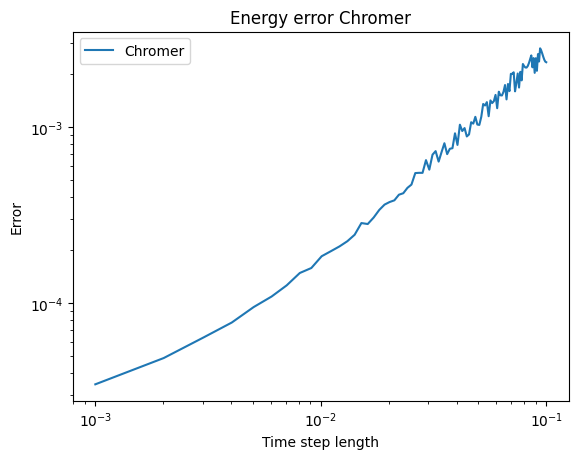

In [ ]:
plt.loglog(times, E_D_CHROMER[:-1], label="Chromer")
plt.xlabel('Time step length')
plt.ylabel('Error')
plt.title('Energy error Chromer')
plt.legend()


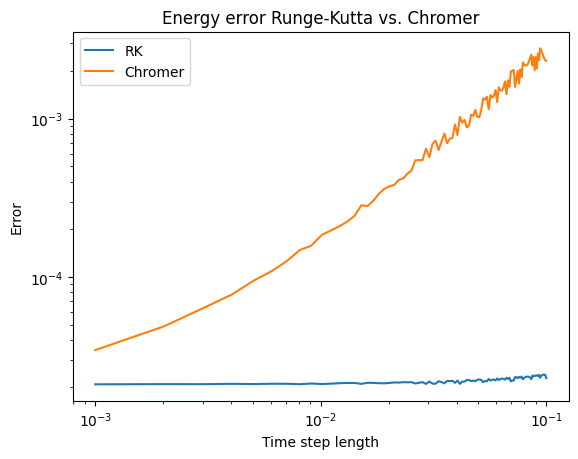

In [ ]:
plt.loglog(times, E_D_RTK[:-1], label="RK")
plt.loglog(times, E_D_CHROMER[:-1], label="Chromer")
plt.xlabel('Time step length')
plt.ylabel('Error')
plt.title('Energy error Runge-Kutta vs. Chromer')
plt.legend()
plt.show()

In [ ]:
def plot_array_values(t_array, y_array, title, label, label_array, x_label, y_label, loc='upper right'):
  fig = plt.figure(figsize=(20, 10))
  ax = fig.subplots()

  for i in range(len(y_array)-1):
    ax.plot(t_array[i], y_array[i], label=f'{label} = {label_array[i]}')

  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  plt.legend(loc=loc)

  plt.show()


# Oppgave 3
Vi ser for 'W = 0' i plottet nedenfor, dvs at drivfrekvensen $\Omega_d$ = 0, får vi en ren dempet svingning av at $sin(\Omega_d) = 0 => F_d = 0$

Det viktigste er imidlertid plottet for $\Omega_d = π \approx 3.13$, som vi har fått oppgitt i oppgaven som verdi å undersøke først. Denne maksimerer amplituden som vi ser i (Amplitude) plottet, betyr at $3.13^{-s}$ er resonans frekvensen som maksimerer amplituden

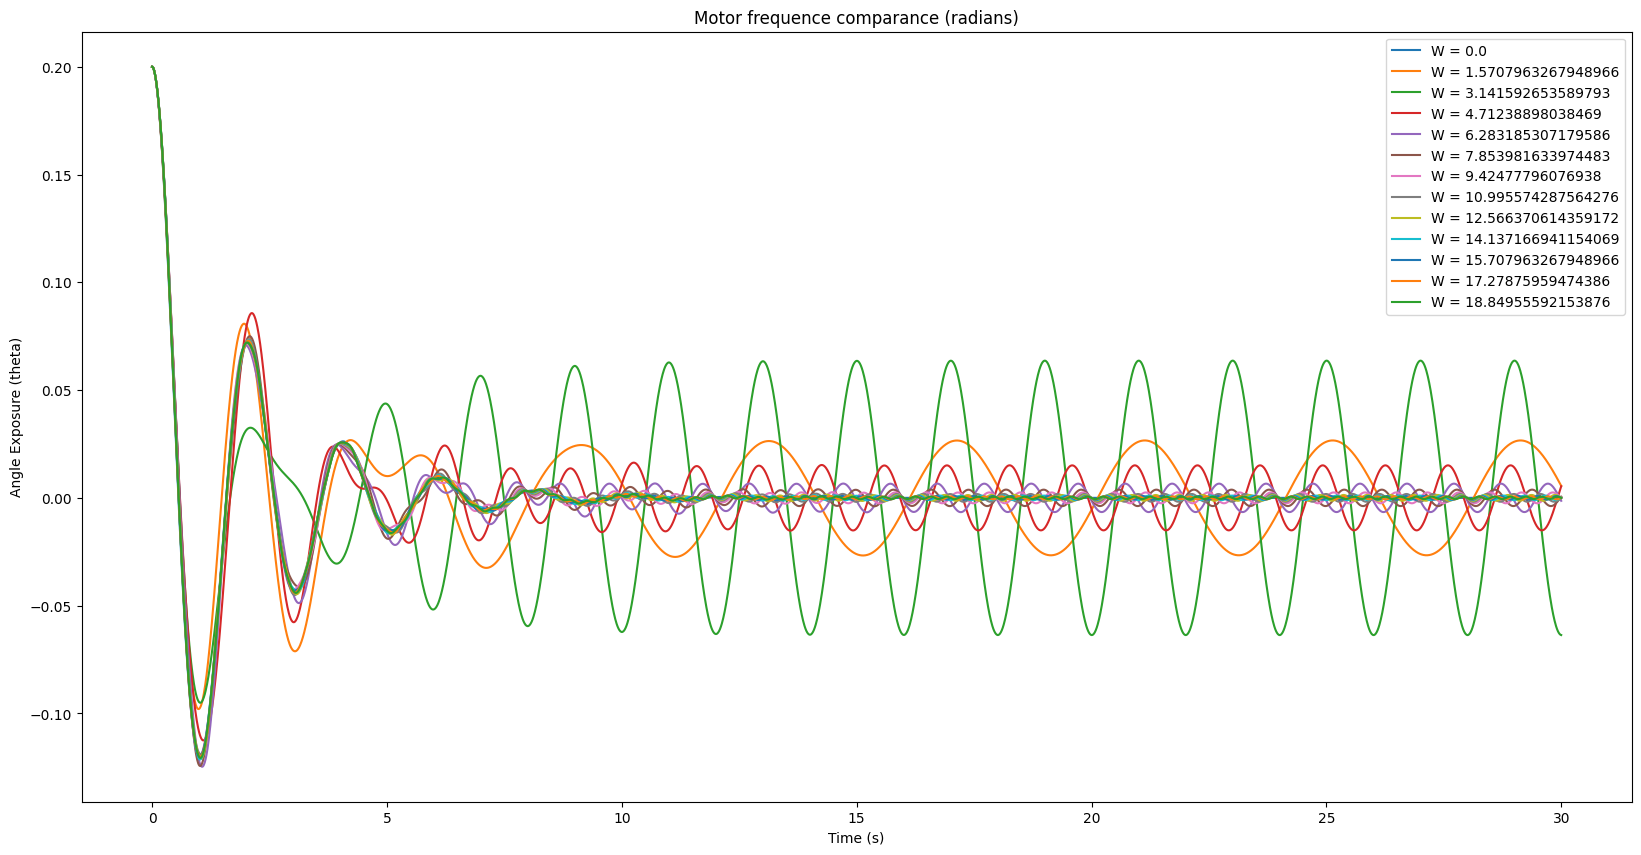

In [ ]:
W_d = np.arange(0, 7*np.pi, np.pi/2)

Y_motor, T_motor = [], []

for w_d in W_d:
  y, omega, t = RTK_4(theta0=0.2, omega0=0.0, W_d=w_d, t0=0.0, tmax=30.0, dt=0.01)
  Y_motor.append(y)
  T_motor.append(t)

plot_array_values(T_motor, Y_motor,'Motor frequence comparance (radians)', 'W', W_d, 'Time (s)', 'Angle Exposure (theta)')


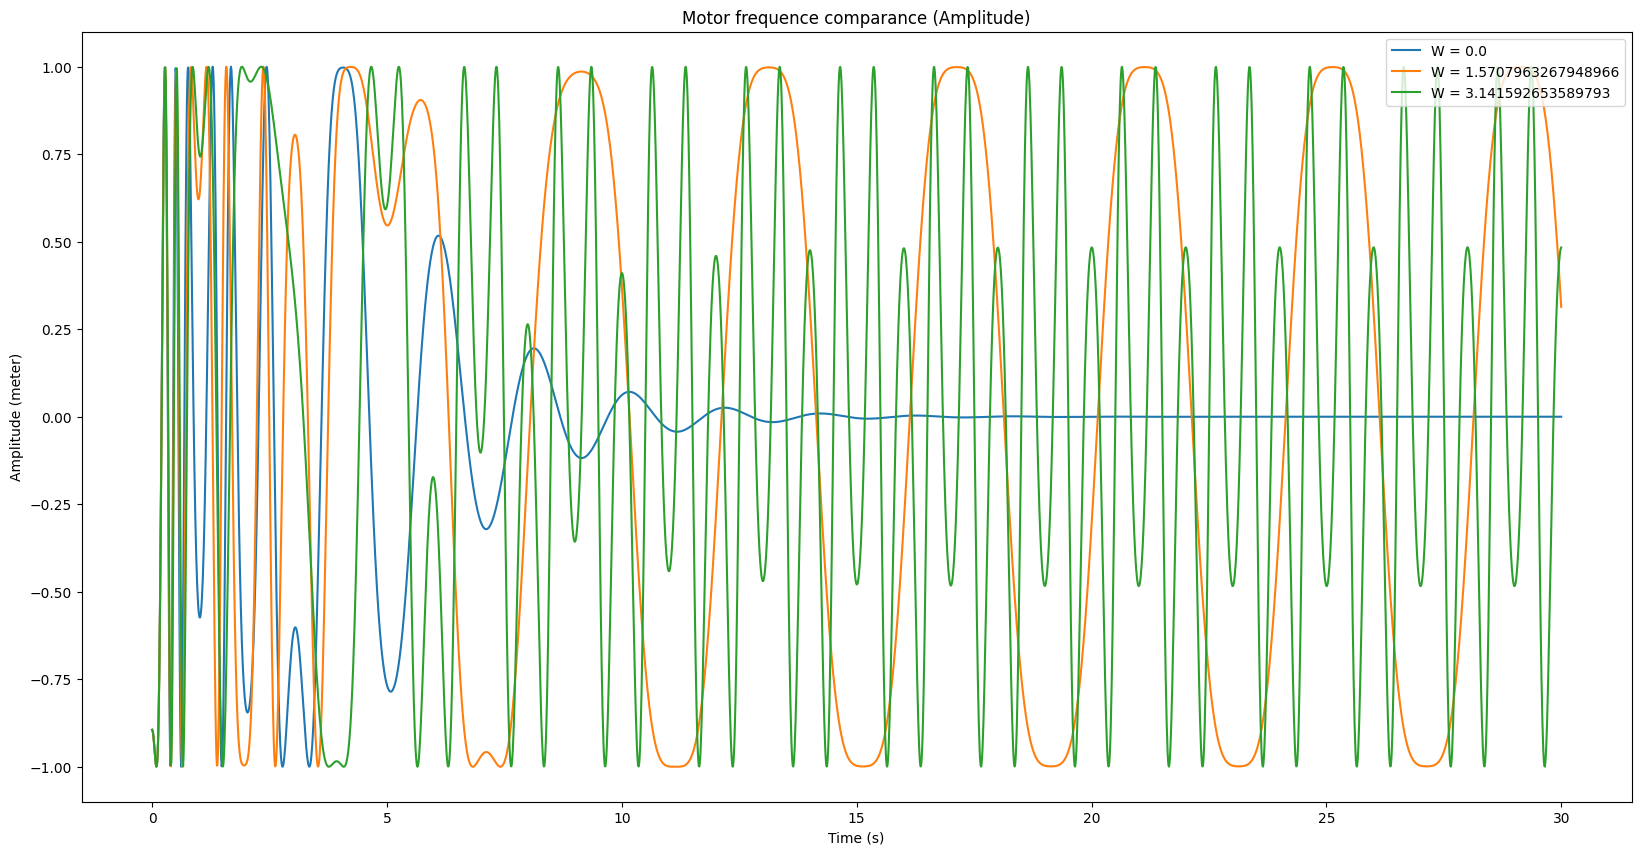

In [ ]:
def angle_exposure_to_amplitude(angle_rad: int) -> int:
  deg = np.rad2deg(angle_rad)
  return L*np.sin(deg)

# y_amp, t_amp = Y_motor[:-int(len(Y_motor)/2)], T_motor[:-int(len(Y_motor)/2)]
y_amp, t_amp = Y_motor, T_motor
y_amp = [[angle_exposure_to_amplitude(x) for x in y] for y in y_amp[0:-10]]

plot_array_values(t_amp, y_amp,'Motor frequence comparance (Amplitude)', 'W', W_d,  'Time (s)', 'Amplitude (meter)')



# Oppgave 4

Som vi ser i plottet nedenfor, vil vi for 'q = 1' og 'q = 2' ha et systemet som ressonere for $\Omega_d = 3.13$

For $q ≥ 4$ får vi fullstendig kritisk dempet system

For $q ∈ [2, 3]$ har vi et underdempet system

In [ ]:
def damped_pendulum(t, y, q_coef, W_d):

    theta, omega = y
    dtheta_dt = omega
    domega_dt = - q_coef * omega - (g/L) * np.sin(theta)
    return np.array([dtheta_dt, domega_dt])


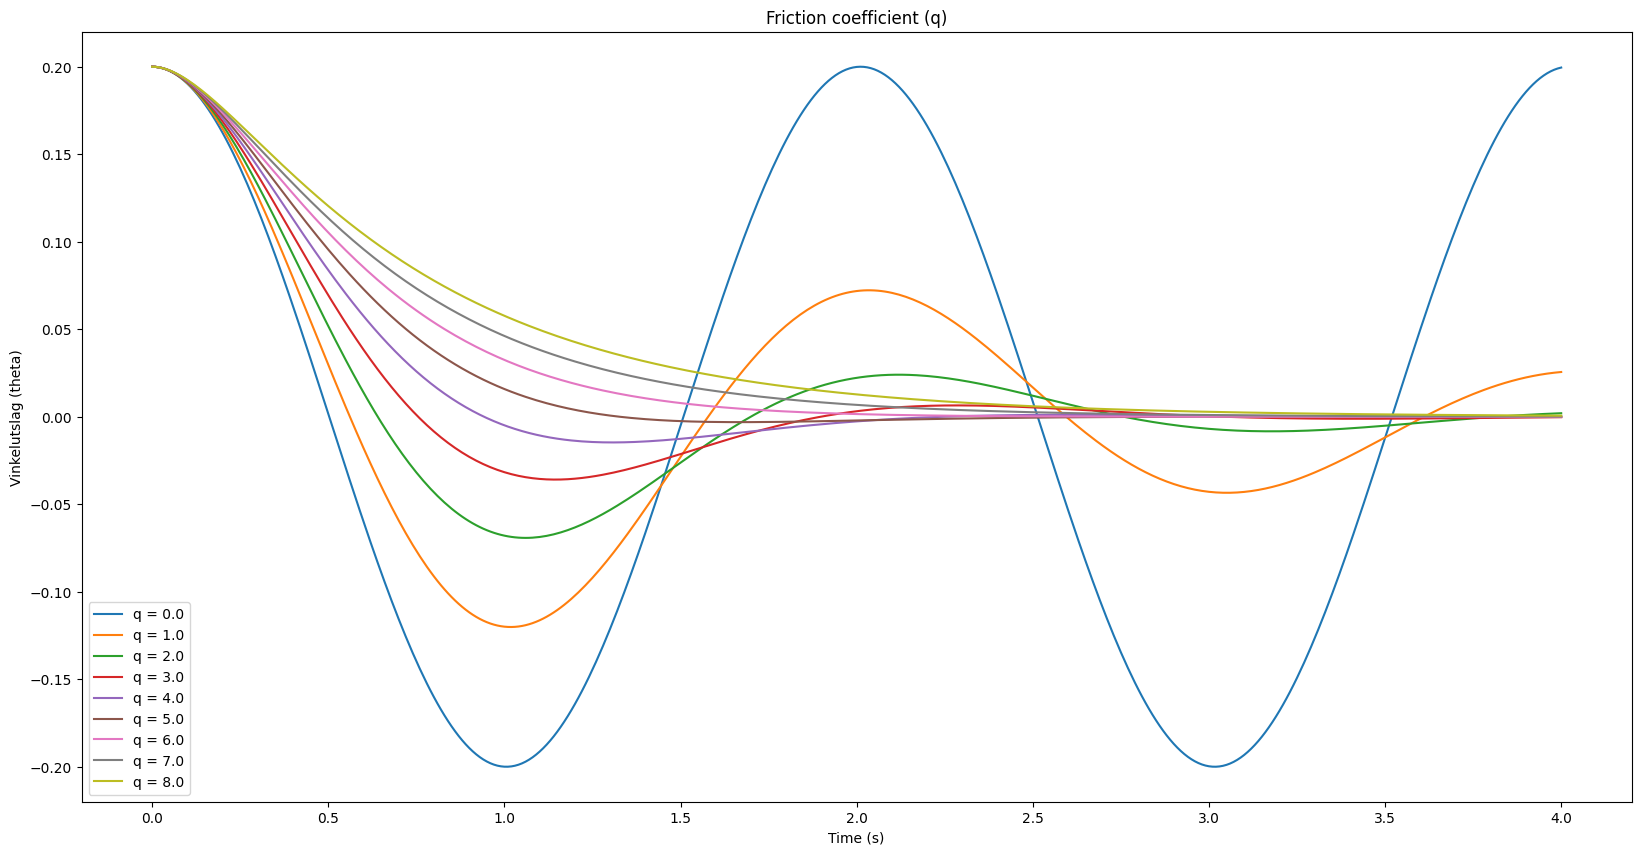

In [ ]:
q_values = np.arange(0, 10.0, 1.0)

Y_friction, T_friction = [], []

for q_i in q_values:
  y_f, omega_f, t_f = RTK_4(f=damped_pendulum, theta0=0.2, omega0=0.0, t0=0.0, tmax=4.0, dt=0.01, q_coef=q_i)
  Y_friction.append(y_f)
  T_friction.append(t_f)

plot_array_values(T_friction, Y_friction,'Friction coefficient (q)', 'q', q_values, 'Time (s)', 'Vinkelutslag (theta)', 'lower left')

# Ekstra &rarr; Finding chaos

In [ ]:
def damped_pendulum_motor_excact_theta(t, y, q_coef, W_d):
    theta, omega = y
    dtheta_dt = omega
    # sin(theta) ~ theta
    domega_dt = -(g/L)*np.sin(theta) - 100*omega + 100*np.sin(W_d*t)
    return np.array([dtheta_dt, domega_dt])

y_ex, omega_ex, t_ex = RTK_4(theta0=np.deg2rad(60), omega0=0.0, f=damped_pendulum_motor_excact_theta, W_d=100, t0=0.0, tmax=30.0, dt=0.01)

In [ ]:
# Plot the results
plt.plot(t_ex, y_ex)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Damped and Driven Pendulum')
plt.show()